## LIBRERIAS

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from stastmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from functools import partial# import ace_tools as tools

### Rutas y Archivos

In [5]:
sellin_path = 'data/sell-in.txt.gz'
prod_predecir_path = 'data/tb_prod_predecir.txt'
products_path = 'data/tb_productos.txt'
stocks_path = 'data/tb_stocks.txt'

### CARGAR DATOS

In [6]:
sell_in = pd.read_csv(sellin_path, compression='gzip', sep='\t')
prod_predecir = pd.read_csv(prod_predecir_path, sep='\t')  
productos = pd.read_csv(products_path, sep='\t')
stocks= pd.read_csv(stocks_path, sep='\t')

### Comienzo a transformar mi dataset
Armo un dataset donde solo voy a tener los 780 productos que tengo que pronosticar

sell_in_prod_predict cantidad de registos = 2293481

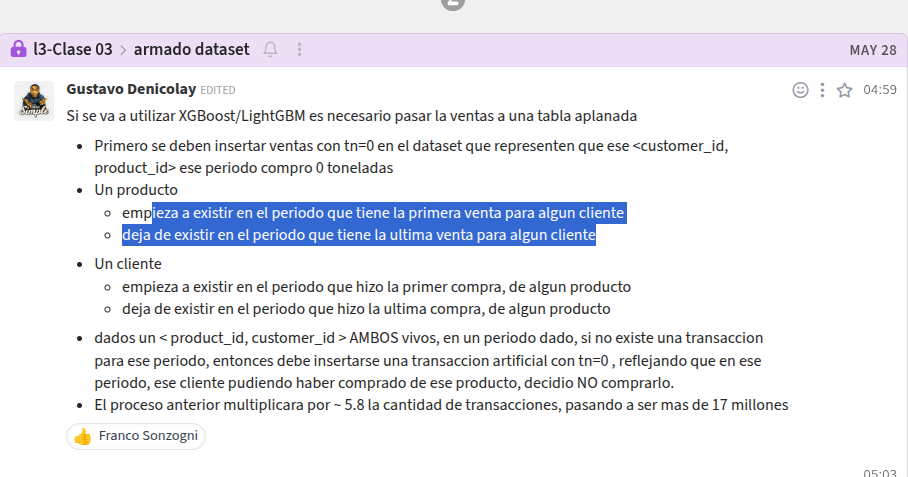

In [9]:
sell_in_prod_predecir = pd.merge(
    sell_in, 
    prod_predecir, 
    on='product_id',  # Especifica la columna común para el join
    how='inner'       # Solo incluir registros que coinciden en ambas tablas
)

# 201701 → 2017-01-01
sell_in_prod_predecir["periodo_dt"] = pd.to_datetime(sell_in_prod_predecir["periodo"].astype(str) + "01", format="%Y%m%d")
sell_in_prod_predecir.drop(columns="periodo", inplace=True)

df = sell_in_prod_predecir.copy()
# downcast para ahorrar RAM
df = df.astype({
    "customer_id":            "int32",
    "product_id":             "int32",
    "plan_precios_cuidados":  "int8",
    "cust_request_qty":       "int32",
    "cust_request_tn":        "float32",
    "tn":                     "float32",
})

In [ ]:

df["periodo_dt"] = (
    pd.to_datetime(df["periodo_dt"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# ──────────────────────────────────────────────────────────────
# 1. Primer y último periodo con ventas por CLIENTE
# ──────────────────────────────────────────────────────────────
cust_span = (df.groupby("customer_id")["periodo_dt"]
               .agg(c_start="min", c_end="max"))

# ──────────────────────────────────────────────────────────────
# 2. Primer y último periodo con ventas por PRODUCTO
# ──────────────────────────────────────────────────────────────
prod_span = (df.groupby("product_id")["periodo_dt"]
               .agg(p_start="min", p_end="max"))

# ──────────────────────────────────────────────────────────────
# 3. Producto cartesiano cliente × producto
# ──────────────────────────────────────────────────────────────
pairs = (
    cust_span.reset_index()
             .assign(key=1)                     # columna dummy para cross-join
    .merge(
        prod_span.reset_index().assign(key=1),
        on="key",
        how="outer",        # equi-valente a CROSS JOIN
        suffixes=("", "")
    )
    .drop(columns="key")
)

# ──────────────────────────────────────────────────────────────
# 4. Para cada par: rango vivo = [max(start), min(end)]
# ──────────────────────────────────────────────────────────────
pairs["start"] = pairs[["c_start", "p_start"]].max(axis=1)
pairs["end"]   = pairs[["c_end",   "p_end"]].min(axis=1)

# ──────────────────────────────────────────────────────────────
# 5. Quedarse sólo con pares donde start ≤ end
# ──────────────────────────────────────────────────────────────
pairs = pairs.loc[pairs["start"] <= pairs["end"]].reset_index(drop=True)

# ──────────────────────────────────────────────────────────────
# 6. Generar todos los meses entre start y end
#    • totalmente vectorizado (repeat + tile)
#    • sin for-loops
# ──────────────────────────────────────────────────────────────
# nº de meses por par  (inclusive)
n_months = (
    (pairs["end"].dt.year  - pairs["start"].dt.year)  * 12
  + (pairs["end"].dt.month - pairs["start"].dt.month)
  + 1
).astype("int16")

# Repetir las filas 'pairs' y crear offsets 0..n-1
rep_idx  = pairs.index.repeat(n_months)
base     = pairs.loc[rep_idx].reset_index(drop=True)

offsets  = np.concatenate([np.arange(k, dtype="int16") for k in n_months])

# Nueva columna periodo_dt = start + offset  (como Period[M] → timestamp)
base["periodo_dt"] = (
    (base["start"].dt.to_period("M") + offsets)
    .astype("datetime64[ns]")
)

calendar = base[["customer_id", "product_id", "periodo_dt"]]

# ──────────────────────────────────────────────────────────────
# 7. Left-join con ventas reales  +  rellenar huecos a 0
# ──────────────────────────────────────────────────────────────
full = (calendar
        .merge(df, how="left",
               on=["customer_id","product_id","periodo_dt"],
               validate="1:1"))

num_cols = ["tn", "cust_request_tn", "cust_request_qty"]
full[num_cols] = full[num_cols].fillna(0)

full["plan_precios_cuidados"] = (
    full["plan_precios_cuidados"].fillna(0).astype("int8")
)

full["is_synth"] = (full["tn"] == 0) & full["cust_request_tn"].eq(0)

print(f"✅  Dataset completado  (cliente × producto vivos): {len(full):,} filas")
print(f"   Memoria: {full.memory_usage(deep=True).sum()/1e6:.1f} MB")

# (opcional) guardar para recarga rápida
full.to_parquet("data/sell_in_cartesian_completed.parquet", compression="zstd")


✅  Dataset completado  (cliente × producto vivos): 11,029,110 filas
   Memoria: 375.0 MB


In [91]:
df_cartesian = pd.read_parquet("data/sell_in_cartesian_completed.parquet")

In [99]:
# Aseguramos fecha primer-de-mes (freq 'MS') para evitar desajustes
df_cartesian["periodo_dt"] = (
    pd.to_datetime(df_cartesian["periodo_dt"])
      .dt.to_period("M")
      .dt.to_timestamp()          # 2017-01-01, 2017-02-01, …
)

# ------------------------------------------------------------------
# 1. Calendario global de los 36 meses  (fixed window)
# ------------------------------------------------------------------
months_36 = pd.date_range("2017-01-01", "2019-12-01", freq="MS")
assert len(months_36) == 36, "La ventana debe tener 36 meses exactos"

# ------------------------------------------------------------------
# 2. Producto cartesiano  (parejas únicas  ×  36 meses)
# ------------------------------------------------------------------
pairs = df_cartesian[["customer_id", "product_id"]].drop_duplicates()
N     = len(pairs)

base            = pairs.loc[pairs.index.repeat(36)].reset_index(drop=True)
base["periodo_dt"] = np.tile(months_36, N)

calendar36 = base[["customer_id", "product_id", "periodo_dt"]]

# ------------------------------------------------------------------
# 3. Left-join con ventas reales  +  rellenar huecos
# ------------------------------------------------------------------
out = (calendar36
       .merge(df_cartesian,
              on=["customer_id", "product_id", "periodo_dt"],
              how="left",
              validate="1:1"))

num_cols = ["tn", "cust_request_tn", "cust_request_qty"]
out[num_cols] = out[num_cols].fillna(0)

# plan_precios_cuidados  ➜  valor más frecuente del par (o 0)
def fill_mode(s):
    m = s.mode()
    return m.iat[0] if not m.empty else 0

out["plan_precios_cuidados"] = (
    out.groupby(["customer_id","product_id"])["plan_precios_cuidados"]
       .transform(lambda col: col.fillna(fill_mode(col)))
       .astype("int8")
)

# flag sintético para las filas añadidas
out["is_synth_36"] = out["tn"].eq(0) & out["cust_request_tn"].eq(0)

print(f"✅ Dataset padded a 36 meses: {len(out):,} filas")
print(f"   Memoria: {out.memory_usage(deep=True).sum()/1e6:.1f} MB")

# ------------------------------------------------------------------
# 4. Guardar (opcional)
# ------------------------------------------------------------------
out.to_parquet("data/sell_in_fixed36.parquet", compression="zstd")

✅ Dataset padded a 36 meses: 16,210,404 filas
   Memoria: 1114.0 MB


### LEO EL DATASET CON 16.2 M DE REGISTROS

In [16]:
dffinal = pd.read_parquet("data/sell_in_fixed36.parquet")
len(dffinal)

16210404

## CODIGO PARA CHEQUEAR POR CUSTOMER Y PRODUCT

In [ ]:
customer=10604
product= 20637
filtered_data = dffinal[(dffinal['product_id'] == product) & (dffinal['customer_id'] == customer)]
filtered_data.head(40)

Agrego el periodo indice de 0 a 35

In [18]:
periodo_mapping = {
    pd.to_datetime("2017-01-01"): 0, pd.to_datetime("2017-02-01"): 1, pd.to_datetime("2017-03-01"): 2,
    pd.to_datetime("2017-04-01"): 3, pd.to_datetime("2017-05-01"): 4, pd.to_datetime("2017-06-01"): 5,
    pd.to_datetime("2017-07-01"): 6, pd.to_datetime("2017-08-01"): 7, pd.to_datetime("2017-09-01"): 8,
    pd.to_datetime("2017-10-01"): 9, pd.to_datetime("2017-11-01"): 10, pd.to_datetime("2017-12-01"): 11,
    pd.to_datetime("2018-01-01"): 12, pd.to_datetime("2018-02-01"): 13, pd.to_datetime("2018-03-01"): 14,
    pd.to_datetime("2018-04-01"): 15, pd.to_datetime("2018-05-01"): 16, pd.to_datetime("2018-06-01"): 17,
    pd.to_datetime("2018-07-01"): 18, pd.to_datetime("2018-08-01"): 19, pd.to_datetime("2018-09-01"): 20,
    pd.to_datetime("2018-10-01"): 21, pd.to_datetime("2018-11-01"): 22, pd.to_datetime("2018-12-01"): 23,
    pd.to_datetime("2019-01-01"): 24, pd.to_datetime("2019-02-01"): 25, pd.to_datetime("2019-03-01"): 26,
    pd.to_datetime("2019-04-01"): 27, pd.to_datetime("2019-05-01"): 28, pd.to_datetime("2019-06-01"): 29,
    pd.to_datetime("2019-07-01"): 30, pd.to_datetime("2019-08-01"): 31, pd.to_datetime("2019-09-01"): 32,
    pd.to_datetime("2019-10-01"): 33, pd.to_datetime("2019-11-01"): 34, pd.to_datetime("2019-12-01"): 35
}

# Agregar la columna periodo_indice al DataFrame usando el mapeo
dffinal['periodo_indice'] = dffinal['periodo_dt'].map(periodo_mapping)

# Mostrar las primeras filas del DataFrame actualizado
# print(dffinal.head())

### Merge con el dataset productos

In [19]:
dffinal = pd.merge(dffinal, productos, on='product_id', how='left')
# Identificar las columnas de tipo object
object_columns = ['cat1','cat2','cat3','brand']

# Convertir las columnas de tipo object a numéricas
for col in object_columns:
    productos[col] = pd.to_numeric(productos[col], errors='coerce')


### Creo clase y lags

In [20]:
dffinal = dffinal.sort_values(["product_id","customer_id", "periodo_dt"])

# tn adelantado 2 periodos (h=2)
dffinal["clase"] = (
    dffinal.groupby(["product_id","customer_id"])["tn"]
      .shift(-2)          # -2 = lead de 2 meses
      .astype("float32")  # mismo tipo que tn para ahorrar RAM
)

# Generar columnas tn-1, tn-2, ..., tn-11 (12 meses de adelanto)
for i in range(1, 12):
    dffinal[f"tn-{i}"] = (
        dffinal.groupby(["product_id", "customer_id"])["tn"]
          .shift(+i)          # -i = lead de i meses
          .astype("float32")  # mismo tipo que tn para ahorrar RAM
    )



In [23]:
dffinal.iloc[:, 6:].head(40)
# dffinal.head(40)

,tn,is_synth,is_synth_36,periodo_indice,cat1,cat2,cat3,brand,sku_size,clase,...,tn-2,tn-3,tn-4,tn-5,tn-6,tn-7,tn-8,tn-9,tn-10,tn-11
0,99.438606,False,False,0,HC,ROPA LAVADO,Liquido,ARIEL,3000,92.465370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,198.843643,False,False,1,HC,ROPA LAVADO,Liquido,ARIEL,3000,13.297280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,92.465370,False,False,2,HC,ROPA LAVADO,Liquido,ARIEL,3000,101.005630,...,99.438606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13.297280,False,False,3,HC,ROPA LAVADO,Liquido,ARIEL,3000,128.047913,...,198.843643,99.438606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101.005630,False,False,4,HC,ROPA LAVADO,Liquido,ARIEL,3000,101.207108,...,92.465370,198.843643,99.438606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,128.047913,False,False,5,HC,ROPA LAVADO,Liquido,ARIEL,3000,43.339298,...,13.297280,92.465370,198.843643,99.438606,NaN,NaN,NaN,NaN,NaN,NaN
6,101.207108,False,False,6,HC,ROPA LAVADO,Liquido,ARIEL,3000,289.350250,...,101.005630,13.297280,92.465370,198.843643,99.438606,NaN,NaN,NaN,NaN,NaN
7,43.339298,False,False,7,HC,ROPA LAVADO,Liquido,ARIEL,3000,222.113892,...,128.047913,101.005630,13.297280,92.465370,198.843643,99.438606,NaN,NaN,NaN,NaN
8,289.350250,False,False,8,HC,ROPA LAVADO,Liquido,ARIEL,3000,111.549438,...,101.207108,128.047913,101.005630,13.297280,92.465370,198.843643,99.438606,NaN,NaN,NaN
9,222.113892,False,False,9,HC,ROPA LAVADO,Liquido,ARIEL,3000,131.271500,...,43.339298,101.207108,128.047913,101.005630,13.297280,92.465370,198.843643,99.438606,NaN,NaN


In [22]:
dffinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16422912 entries, 0 to 16215443
Data columns (total 27 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   customer_id            int32         
 1   product_id             int32         
 2   periodo_dt             datetime64[ns]
 3   plan_precios_cuidados  int8          
 4   cust_request_qty       float64       
 5   cust_request_tn        float32       
 6   tn                     float32       
 7   is_synth               object        
 8   is_synth_36            bool          
 9   periodo_indice         int64         
 10  cat1                   object        
 11  cat2                   object        
 12  cat3                   object        
 13  brand                  object        
 14  sku_size               int64         
 15  clase                  float32       
 16  tn-1                   float32       
 17  tn-2                   float32       
 18  tn-3                   fl

In [15]:
productos

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288
...,...,...,...,...,...,...
1257,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,12,20240
1258,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,6,20285
1259,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,2,20259
1260,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,12,20142
